# CIFAR3 Calibration Benchmark

In [1]:
%load_ext autoreload

In [2]:
%autoreload 1

In [19]:
import os
import sys
import time
import itertools
sys.path.append('..')

import ternary
from ternary import scatter
import numpy as np
import tensorflow as tf
from scipy.special import softmax
import matplotlib.pyplot as plt

%aimport utils
%aimport utils.ops
%aimport utils.metrics
%aimport utils.visualization
%aimport flows.nice
%aimport calibrators
from utils.data import get_cifar3, load_logits
from utils.ops import onehot_encode
from utils.metrics import neg_log_likelihood, expected_calibration_error
from utils.visualization import plot_pdf_simplex, plot_prob_simplex, reliability_diagram, plot_cal_regions_ternary, plot_nll_curve
from calibrators import NiceCalibrator, PlanarFlowCalibrator, RadialFlowCalibrator, RealNvpCalibrator, TempScalingCalibrator, DummyCalibrator 

In [4]:
# Select GPU to use
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 

In [5]:
%matplotlib inline
np.random.seed(1)

### Helper methods:

In [6]:
def add_spoiling_samples(ax, pred_probs, target, probs):
    indv_nll = -np.sum(target*np.log(pred_probs+1e-7), axis=1)
    # spoiling_idx = np.argsort(indv_nll)[:-21:-1]
    spoiling_probs = probs[indv_nll>=np.log2(3), :]
    spoiling_target = np.argmax(target[indv_nll>=np.log2(3), :], axis=1)

    ax.scatter(spoiling_probs[spoiling_target==0, :]*ax._scale, s=50, color='red', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==1, :]*ax._scale, s=50, color='green', edgecolors='k', lw=1, zorder=2)
    ax.scatter(spoiling_probs[spoiling_target==2, :]*ax._scale, s=50, color='blue', edgecolors='k', lw=1, zorder=2)
    

    return ax

## Load data

In [7]:
cifar_dir = '../cifar-10'
models_dir = '../pretrained-models'

In [8]:
model = 'cnn_cifar3'

cifar3, ix2label = get_cifar3(cifar_dir, test=True)
target = onehot_encode(cifar3['test_labels'])

_, logits = load_logits(os.path.join(models_dir, model))
probs = softmax(logits, axis=1)

# val/test split
random_split = np.random.permutation(3000)

val_target = target[random_split[:1500], :]
test_target = target[random_split[1500:], :]

val_logits = logits[random_split[:1500], :]
test_logits = logits[random_split[1500:], :]

In [20]:
## Uncalibrated model.
uncal = DummyCalibrator(val_logits, val_target)

## Calibrating NICE
Select number of flow stages:

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Fitted in 27.160s
Fitted in 36.997s
Fitted in 44.426s
Fitted in 117.098s


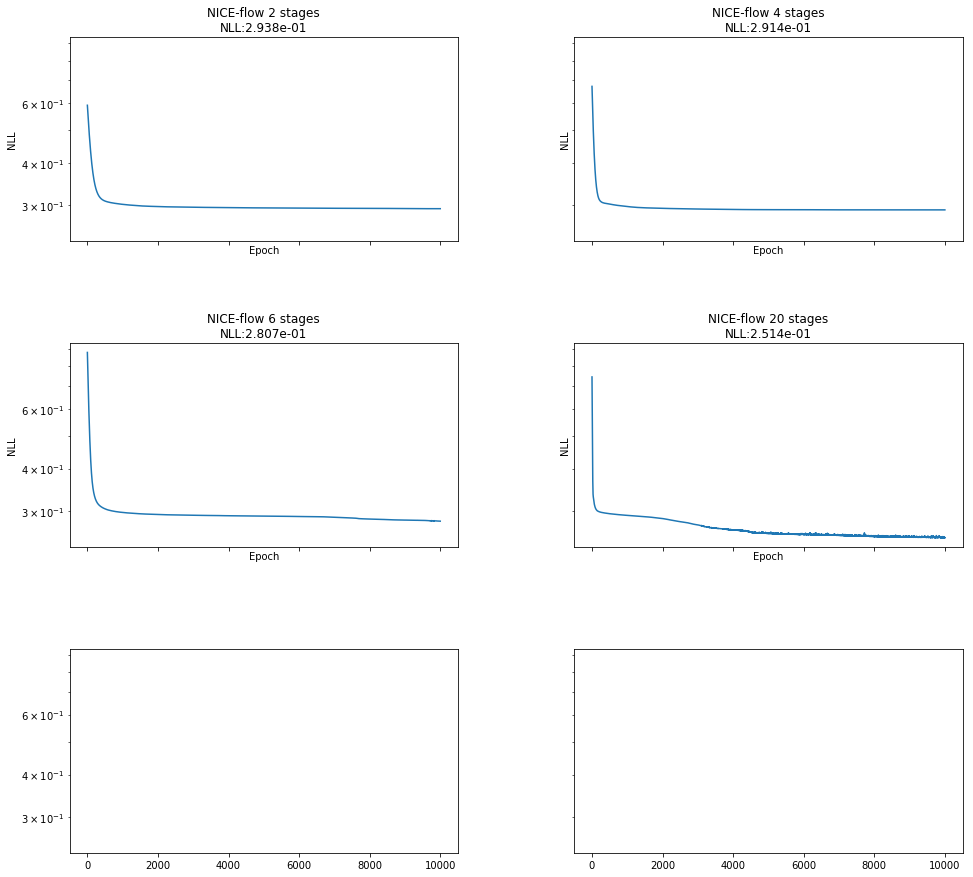

In [9]:
epochs = 10000
batch_size = val_logits.shape[0]
hidd_size = [3]

t0 = time.time()
nice_cal_2 = NiceCalibrator(val_logits, val_target, layers=2, hidden_size=hidd_size,
                            version=3, epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_4 = NiceCalibrator(val_logits, val_target, layers=4, hidden_size=hidd_size,
                            version=3, epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
nice_cal_6 = NiceCalibrator(val_logits, val_target, layers=6, hidden_size=hidd_size,
                            version=3, epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))


t0 = time.time()
nice_cal_20 = NiceCalibrator(val_logits, val_target, layers=20, hidden_size=hidd_size,
                             version=3, epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 15), sharex='all', sharey='all', gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

ax_arr[0, 0].plot(nice_cal_2.history.history['loss'])
ax_arr[0, 0].set_title('NICE-flow 2 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_2(val_logits), val_target)))
ax_arr[0, 0].set_ylabel('NLL')
ax_arr[0, 0].set_xlabel('Epoch')
ax_arr[0, 0].set_yscale('log')

ax_arr[0, 1].plot(nice_cal_4.history.history['loss'])
ax_arr[0, 1].set_title('NICE-flow 4 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_4(val_logits), val_target)))
ax_arr[0, 1].set_ylabel('NLL')
ax_arr[0, 1].set_xlabel('Epoch')
ax_arr[0, 1].set_yscale('log')

ax_arr[1, 0].plot(nice_cal_6.history.history['loss'])
ax_arr[1, 0].set_title('NICE-flow 6 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_6(val_logits), val_target)))
ax_arr[1, 0].set_ylabel('NLL')
ax_arr[1, 0].set_xlabel('Epoch')
ax_arr[1, 0].set_yscale('log')

ax_arr[1, 1].plot(nice_cal_20.history.history['loss'])
ax_arr[1, 1].set_title('NICE-flow 20 stages\nNLL:{:.3e}'.format(neg_log_likelihood(nice_cal_20(val_logits), val_target)))
ax_arr[1, 1].set_ylabel('NLL')
ax_arr[1, 1].set_xlabel('Epoch')
ax_arr[1, 1].set_yscale('log')

plt.show()

### Effect of number of layers on simplex

..\calibrators.py:41: RuntimeWarning: divide by zero encountered in log
  return softmax(np.log(probs) - self.log_priors, axis=1)


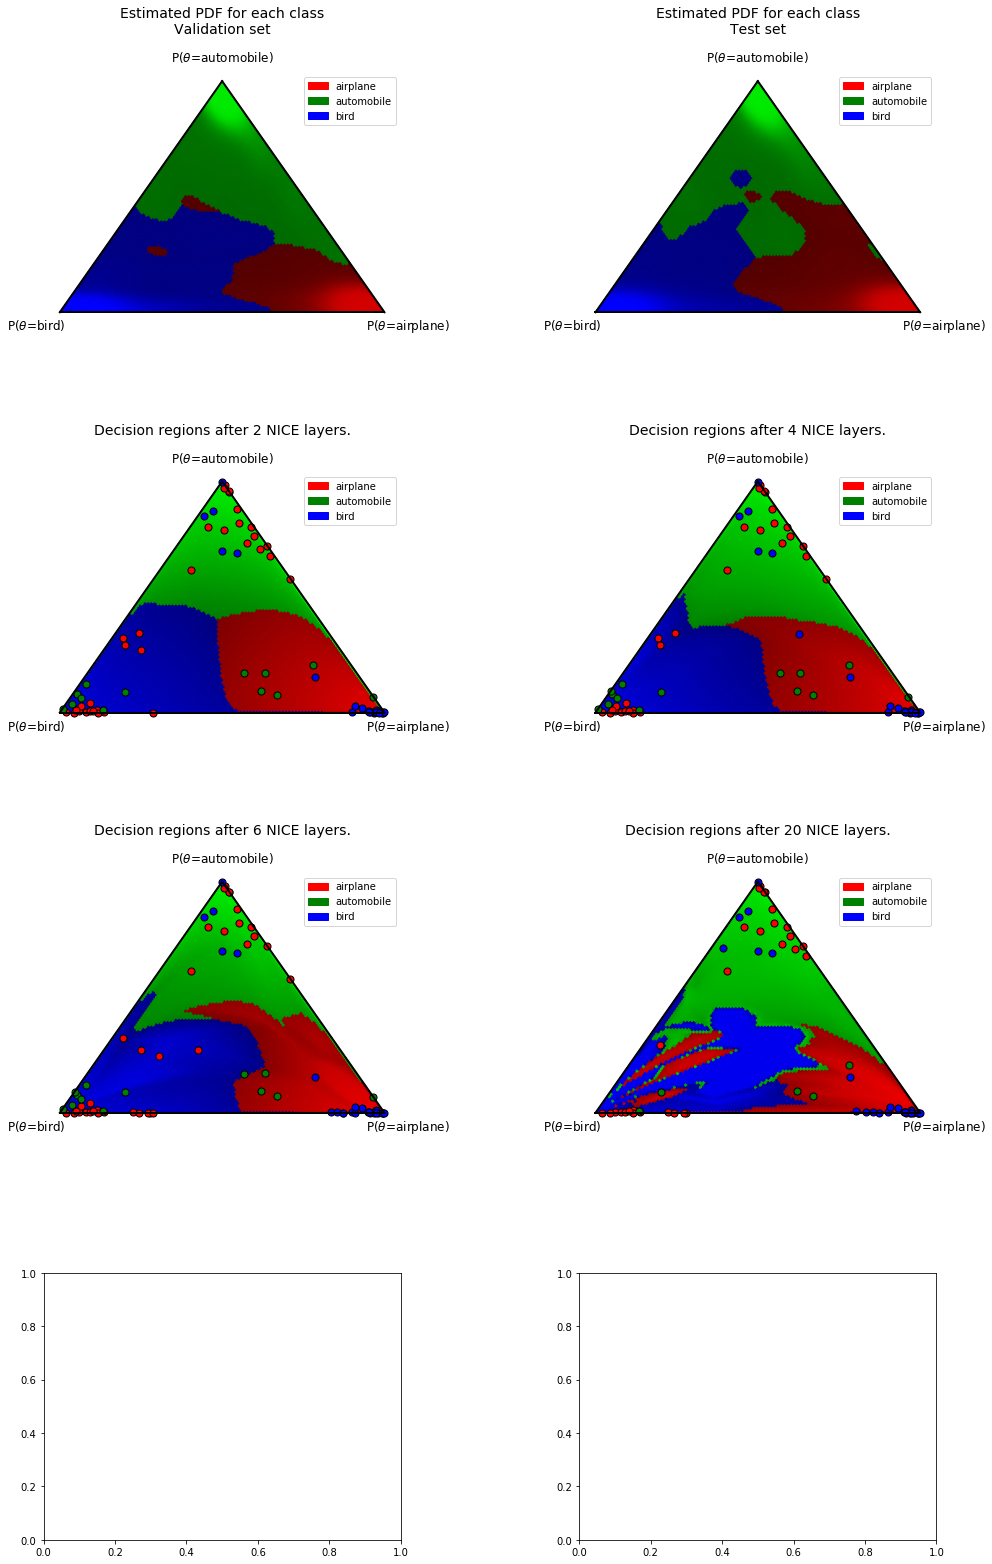

In [10]:
fig, ax_arr = plt.subplots(3, 2, figsize=(16, 27), gridspec_kw={'hspace': 0.5, 'wspace': 0.5})

ax_arr[0, 0] = plot_pdf_simplex(softmax(val_logits, axis=1), target=val_target, ax=ax_arr[0, 0], scale=100,
                             title='Estimated PDF for each class\nValidation set', fontsize=12, labels=list(ix2label.values()));
ax_arr[0, 1] = plot_pdf_simplex(softmax(test_logits, axis=1), target=test_target, ax=ax_arr[0, 1], scale=100,
                             title='Estimated PDF for each class\nTest set', fontsize=12, labels=list(ix2label.values()));


ax_arr[1, 0] = plot_cal_regions_ternary(nice_cal_2, ax=ax_arr[1, 0], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 2 NICE layers.', fontsize=12);
ax_arr[1, 0] = add_spoiling_samples(ax_arr[1, 0], nice_cal_2(val_logits), val_target, softmax(val_logits, axis=1))
ax_arr[1, 1] = plot_cal_regions_ternary(nice_cal_4, ax=ax_arr[1, 1], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 4 NICE layers.', fontsize=12);
ax_arr[1, 1] = add_spoiling_samples(ax_arr[1, 1], nice_cal_4(val_logits), val_target, softmax(val_logits, axis=1))

ax_arr[2, 0] = plot_cal_regions_ternary(nice_cal_6, ax=ax_arr[2, 0], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 6 NICE layers.', fontsize=12);
ax_arr[2, 0] = add_spoiling_samples(ax_arr[2, 0], nice_cal_6(val_logits), val_target, softmax(val_logits, axis=1))
ax_arr[2, 1] = plot_cal_regions_ternary(nice_cal_20, ax=ax_arr[2, 1], scale=100, labels=list(ix2label.values()),
                                        title='Decision regions after 20 NICE layers.', fontsize=12);
ax_arr[2, 1] = add_spoiling_samples(ax_arr[2, 1], nice_cal_20(val_logits), val_target, softmax(val_logits, axis=1))

plt.show()

### Calibrating RealNVP

Fitted in 38.255s
Fitted in 55.145s
Fitted in 72.160s
Fitted in 184.487s


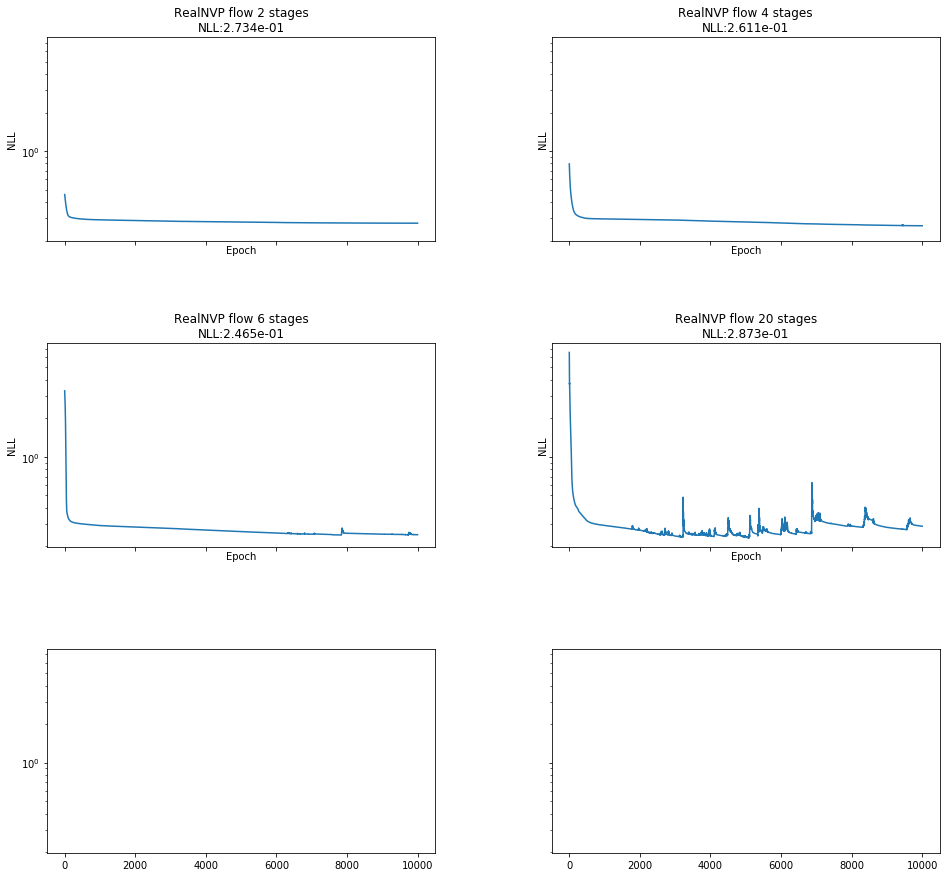

In [11]:
epochs = 10000
batch_size = val_logits.shape[0]
hidd_size = [3]

t0 = time.time()
rnvp_cal_2 = RealNvpCalibrator(val_logits, val_target, layers=2, hidden_size=hidd_size,
                               epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
rnvp_cal_4 = RealNvpCalibrator(val_logits, val_target, layers=4, hidden_size=hidd_size,
                               epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
rnvp_cal_6 = RealNvpCalibrator(val_logits, val_target, layers=6, hidden_size=hidd_size,
                               epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

t0 = time.time()
rnvp_cal_20 = RealNvpCalibrator(val_logits, val_target, layers=20, hidden_size=hidd_size,
                                epochs=epochs, batch_size=batch_size)
print('Fitted in {:.3f}s'.format(time.time()-t0))

# Plot training NLL
fig, ax_arr = plt.subplots(2, 2, figsize=(16, 15), sharex='all', sharey='all', gridspec_kw={'hspace': 0.5, 'wspace': 0.3})

ax_arr[0, 0].plot(rnvp_cal_2.history.history['loss'])
ax_arr[0, 0].set_title('RealNVP flow 2 stages\nNLL:{:.3e}'.format(neg_log_likelihood(rnvp_cal_2(val_logits), val_target)))
ax_arr[0, 0].set_ylabel('NLL')
ax_arr[0, 0].set_xlabel('Epoch')
ax_arr[0, 0].set_yscale('log')

ax_arr[0, 1].plot(rnvp_cal_4.history.history['loss'])
ax_arr[0, 1].set_title('RealNVP flow 4 stages\nNLL:{:.3e}'.format(neg_log_likelihood(rnvp_cal_4(val_logits), val_target)))
ax_arr[0, 1].set_ylabel('NLL')
ax_arr[0, 1].set_xlabel('Epoch')
ax_arr[0, 1].set_yscale('log')

ax_arr[1, 0].plot(rnvp_cal_6.history.history['loss'])
ax_arr[1, 0].set_title('RealNVP flow 6 stages\nNLL:{:.3e}'.format(neg_log_likelihood(rnvp_cal_6(val_logits), val_target)))
ax_arr[1, 0].set_ylabel('NLL')
ax_arr[1, 0].set_xlabel('Epoch')
ax_arr[1, 0].set_yscale('log')

ax_arr[1, 1].plot(rnvp_cal_20.history.history['loss'])
ax_arr[1, 1].set_title('RealNVP flow 20 stages\nNLL:{:.3e}'.format(neg_log_likelihood(rnvp_cal_20(val_logits), val_target)))
ax_arr[1, 1].set_ylabel('NLL')
ax_arr[1, 1].set_xlabel('Epoch')
ax_arr[1, 1].set_yscale('log')

plt.show()

## NLL Curve comparison:

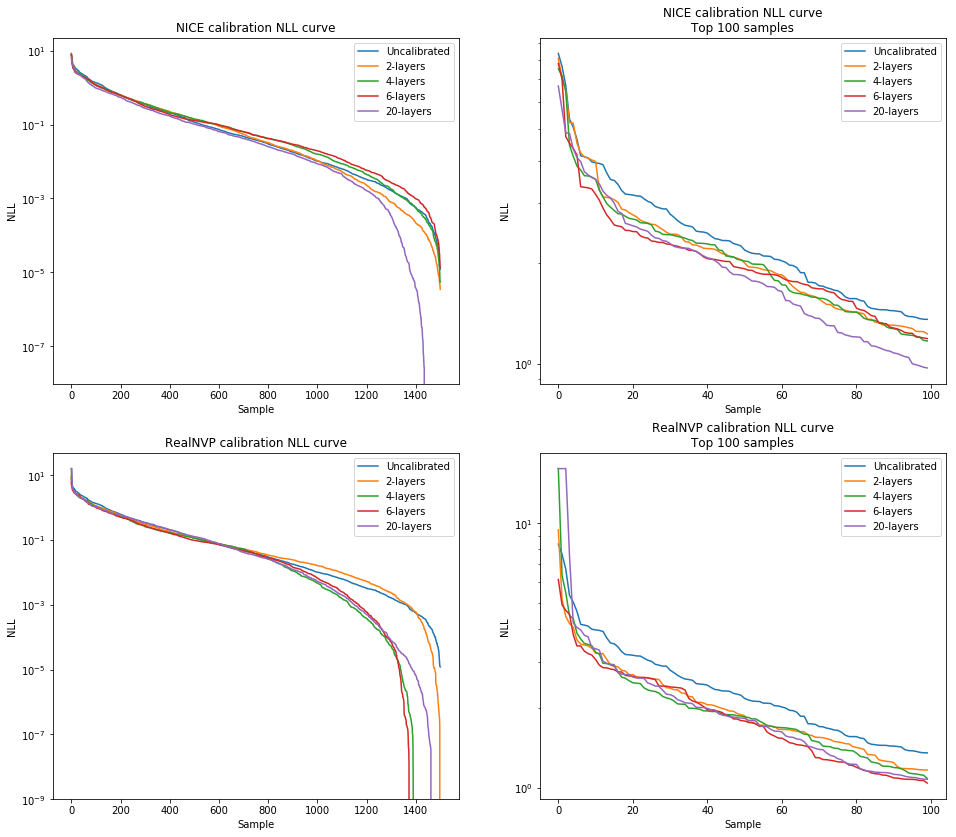

In [21]:
nice_calibrators = [uncal, nice_cal_2, nice_cal_4, nice_cal_6, nice_cal_20]
rnvp_calibrators = [uncal, rnvp_cal_2, rnvp_cal_4, rnvp_cal_6, rnvp_cal_20]
labels = ['Uncalibrated'] + ["{}-layers".format(l) for l in [2, 4, 6, 20]]

fig, ax_arr = plt.subplots(2, 2, figsize=(16, 14))

ax_arr[0, 0] = plot_nll_curve(val_logits, val_target, nice_calibrators, ax=ax_arr[0, 0],
                              labels=labels, title='NICE calibration NLL curve')

ax_arr[0, 1] = plot_nll_curve(val_logits, val_target, nice_calibrators, ax=ax_arr[0, 1],
                              labels=labels, top=100, title='NICE calibration NLL curve\nTop 100 samples')


ax_arr[1, 0] = plot_nll_curve(val_logits, val_target, rnvp_calibrators, ax=ax_arr[1, 0],
                              labels=labels, title='RealNVP calibration NLL curve')

ax_arr[1, 1] = plot_nll_curve(val_logits, val_target, rnvp_calibrators, ax=ax_arr[1, 1],
                              labels=labels, top=100, title='RealNVP calibration NLL curve\nTop 100 samples')

plt.show()